>
> # MaaS Sim 
> * Multiplatform and decision
>
-----

In [1]:
%load_ext autoreload
%autoreload 2
import os, sys # add MaaSSim to path (not needed if MaaSSim is already in path)
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
from MaaSSim.utils import get_config, load_G, save_config, prep_supply_and_demand, generate_demand, generate_vehicles, initialize_df  # simulator
from MaaSSim.data_structures import structures as inData
from MaaSSim.simulators import simulate
from MaaSSim.decisions import f_platform_choice
from dotmap import DotMap
import random
import pandas as pd
import logging
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
plt.rcParams["font.family"] = "Times"
plt.style.use('seaborn-whitegrid')

In [4]:
params = get_config('../../data/config/delft.json')  # load configuration
params.city = 'Delft'
#params = make_config_paths(params)
params.simTime = 4 # 4 hours of simulation
params.nD = 1 # number of days to repeat
params.nP = 1 # reuqests (and passengers)
params.nV = 2 # vehicles
params.times.patience = 600 

In [35]:
df = pd.read_clipboard(sep="	", index_col=0, header = None)
df

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,,,,,,,,,,,,,,,
5,197.1,180.3,156.9,136.9,88.6,118.3,144.2,156.9,164.3,124.1,23.7,28.8,31.4,32.9,24.8
10,298.6,258.5,231.1,177.6,143.8,179.1,206.8,231.1,213.2,201.4,17.9,20.7,23.1,21.3,20.1
15,357.0,324.6,286.3,208.1,181.5,214.2,259.7,286.3,249.7,254.2,14.3,17.3,19.1,16.6,16.9
20,370.8,350.2,267.3,271.8,187.9,222.5,280.2,267.3,326.2,263.0,11.1,14.0,13.4,16.3,13.2
25,393.9,393.7,323.9,278.7,194.1,236.3,314.9,323.9,334.4,271.7,9.5,12.6,13.0,13.4,10.9
30,446.1,363.2,327.1,263.9,222.2,267.6,290.5,327.1,316.7,311.1,8.9,9.7,10.9,10.6,10.4
40,438.5,453.3,340.6,307.5,282.4,263.1,362.6,340.6,369.0,395.3,6.6,9.1,8.5,9.2,9.9


In [31]:
df.iloc[2]

veh km                31.4
revenue               32.9
revenue per driver    24.8
Name: (5, 197.1, 180.3, 156.9, 136.9, 88.6, 118.3, 144.2, 156.9, 164.3, 124.1, 23.7, 28.8), dtype: float64

In [37]:
res = pd.read_csv('pricing.csv', index_col = 0)
res.sample(3)

,fleet,fare,revenue,repl
134,30,1.4,32321.0,3
305,30,0.6,38200.0,8
34,40,1.4,31008.0,0


In [38]:
res['veh km'] = res['revenue']/100
res['revenue'] = res['veh km'] * res['fare']
res['revenue per driver'] = res['revenue']/res['fleet']
res['veh km per driver'] = res['veh km']/res['fleet']
res.groupby(['fleet','fare'])[['veh km','revenue', 'revenue per driver']].mean().unstack().round(1)

veh km                             revenue                              \
fare     0.6    0.8    1.0    1.2    1.4     0.6    0.8    1.0    1.2    1.4   
fleet                                                                          
5      117.9  112.9  105.7   99.7   95.7    70.7   90.3  105.7  119.7  134.0   
10     188.0  191.5  186.6  175.1  158.1   112.8  153.2  186.6  210.1  221.3   
15     239.9  245.3  218.2  224.0  203.0   144.0  196.3  218.2  268.8  284.2   
20     298.3  274.8  250.2  270.9  237.5   179.0  219.8  250.2  325.0  332.5   
25     304.9  300.0  286.4  286.0  284.0   182.9  240.0  286.4  343.2  397.6   
30     336.9  296.3  320.9  298.5  282.6   202.1  237.0  320.9  358.2  395.6   
40     363.7  346.4  340.0  325.2  331.4   218.2  277.1  340.0  390.3  463.9   

      revenue per driver                          
fare                 0.6   0.8   1.0   1.2   1.4  
fleet                                             
5                   14.1  18.1  21.1  23.9  26.8  
10                  11.3  15.3  18.7  21.0  22.1  
15                   9.6  13.1  14.5  17.9  18.9  
20                   8.9  11.0  12.5  16.3  16.6  
25                   7.3   9.6  11.5  13.7  15.9  
30                   6.7   7.9  10.7  11.9  13.2  
40                   5.5   6.9   8.5   9.8  11.6

'Darswk2_r' is not a valid value for name; supported values are 'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'icefire', 'icefire_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'mako', 'mako_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'rocket', 'rocket_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'turbo', 'turbo_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'viridis', 'viridis_r', 'vlag', 'vlag_r', 'winter', 'winter_r'

In [52]:
df['revenue €'] = df['revenue']
df['fleet size [vehs]'] = df['fleet']
df['vehicle kilometers per driver'] = df['veh km per driver']

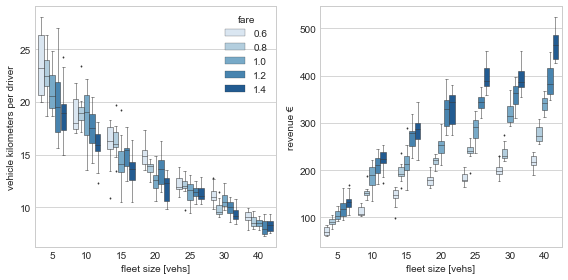

In [57]:
df = res
fig, ax = plt.subplots(1,2,figsize = (8,4))
sns.boxplot(hue='fare', y = 'vehicle kilometers per driver', x = 'fleet size [vehs]', data  = res, 
             hue_order = df.fare.unique(),  palette = 'Blues', ax = ax[0], 
            linewidth = 0.5, flierprops = dict(markerfacecolor = '0.50', markersize = 1))
#ax[0].set_xlim((5,40))
#ax[0].set_ylim((5,50))
sns.boxplot(hue='fare', y = 'revenue €', x = 'fleet size [vehs]', data  = res, hue_order = df.fare.unique(),  
            palette = 'Blues', ax = ax[1], linewidth = 0.5, flierprops = dict(markerfacecolor = '0.50', markersize = 1))
#ax[1].set_xlim((5,40))
#ax[1].set_ylim((100,500))
ax[1].legend().remove()
fig.tight_layout()
plt.savefig('fig6.tif', dpi = 300)

-------------
Rafal Kucharski, 2020, Delft, r.m.kucharski@tudelft.nl